## Работа с большими данными

Твоя задача: используя данные, разделить клиентов на кластеры и ответить на ряд вопросов, которые помогут банку улучшить обслуживание клиентов и оптимизировать маркетинговые предложения.
 

Воспользуйся **Dask** — библиотекой для параллельных вычислений на Python, которая позволяет обрабатывать большие объёмы данных, превышающие объём оперативной памяти отдельно взятого ПК, и эффективно использовать многопроцессорные системы. 

**Данные:** архив card_transactions.zip, в котором содержатся parquet- файлы с данными о карточных трансакциях. 

В основе датасета лежат данные из соревнования Альфы на ODS. https://ods.ai/competitions/dl-fintech-card-transactions/data

In [73]:
from pathlib import Path
import dask.dataframe as dd
import numpy as np
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.cluster import MiniBatchKMeans
import matplotlib.pyplot as plt
import seaborn as sns

*Описание полей:*

client_id — Идентификатор клиента

amnt — Нормированная сумма трансакции. 0.0 — соответствует пропускам

currency — Идентификатор валюты трансакции

operation_kind — Идентификатор типа трансакции

card_type — Уникальный идентификатор типа карты (ип карты, виза/мастеркард/мир и всякие кобрендвовые истории (МИР+АЭрофлот и т.д.))

operation_type — Идентификатор типа операции по пластиковой карте

operation_type_group — Идентификатор группы карточных операций (дебетовый/кредитовый)

ecommerce_flag — Признак электронной коммерции

payment_system — Идентификатор типа платежной системы

income_flag — Признак списания/внесения денежных средств на карту

mcc — Уникальный идентификатор типа торговой точки

country — Идентификатор страны трансакции

city — Идентификатор города трансакции

mcc_category — Идентификатор категории магазина трансакции

day_of_week — День недели, когда трансакция была совершена

hour — Час, когда трансакция была совершена

weekofyear — Номер недели в году, когда трансакция была совершена

hour_diff — Количество часов с момента прошлой трансакции для данного клиента
 

Инициализируй dask.dataframe с использованием имеющихся parquet-файлов. После этого со всем набором файлов можно будет работать как с одним датафреймом.
 

In [102]:
from pathlib import Path
import dask.dataframe as dd

DATA_DIR = Path("Downloads/card_transactions")  
ddf = dd.read_parquet(str(DATA_DIR), engine="pyarrow")

ddf.head(10)

,amnt,currency,operation_kind,card_type,operation_type,operation_type_group,ecommerce_flag,payment_system,income_flag,mcc,country,city,mcc_category,day_of_week,hour,weekofyear,hour_diff,client_id
0,0.465425,1,4,98,4,2,3,7,3,2,1,37,2,4,19,34,-1,5feceb
1,0.000000,1,2,98,7,1,3,7,3,2,1,49,2,4,20,34,0,5feceb
2,0.521152,1,2,98,3,1,3,7,3,2,1,37,2,4,20,34,0,5feceb
3,0.356078,1,1,5,2,1,3,7,3,10,1,49,7,2,0,34,52,5feceb
4,0.000000,1,2,98,7,1,3,7,3,2,1,49,2,4,16,53,280,5feceb
5,0.516834,1,2,98,3,1,3,7,3,2,1,37,2,4,16,53,0,5feceb
6,0.258972,1,2,98,3,1,1,6,1,2,1,2,2,2,18,53,75,5feceb
7,0.297589,1,2,98,3,1,1,6,1,2,1,2,2,2,19,52,169,5feceb
8,0.356078,1,1,5,2,1,1,2,1,10,1,49,7,7,13,52,18,5feceb
9,0.333547,1,1,5,2,1,1,2,1,10,1,49,7,7,13,52,0,5feceb


In [49]:
print(ddf.columns)   
print(ddf.dtypes) 

Index(['amnt', 'currency', 'operation_kind', 'card_type', 'operation_type',
       'operation_type_group', 'ecommerce_flag', 'payment_system',
       'income_flag', 'mcc', 'country', 'city', 'mcc_category', 'day_of_week',
       'hour', 'weekofyear', 'hour_diff', 'client_id'],
      dtype='object')
amnt                            float64
currency                          int32
operation_kind                    int32
card_type                         int32
operation_type                    int32
operation_type_group              int32
ecommerce_flag                    int32
payment_system                    int32
income_flag                       int32
mcc                               int32
country                           int32
city                              int32
mcc_category                      int32
day_of_week                       int32
hour                              int32
weekofyear                        int32
hour_diff                         int64
client_id           

In [82]:
stats = ddf.select_dtypes(include=[np.number]).describe().compute()
print(stats) 

               amnt      currency  operation_kind     card_type  \
count  2.692016e+08  2.704501e+08    2.704501e+08  2.704501e+08   
mean   3.605289e-01  1.087495e+00    1.373798e+00  3.690343e+01   
std    9.608436e-02  7.598704e-01    8.660050e-01  4.048160e+01   
min    5.583518e-04  1.000000e+00    1.000000e+00  1.000000e+00   
25%    3.029119e-01  1.000000e+00    1.000000e+00  1.300000e+01   
50%    3.588630e-01  1.000000e+00    1.000000e+00  4.200000e+01   
75%    4.297594e-01  1.000000e+00    1.000000e+00  7.100000e+01   
max    1.000000e+00  1.100000e+01    7.000000e+00  1.750000e+02   

       operation_type  operation_type_group  ecommerce_flag  payment_system  \
count    2.704501e+08          2.704501e+08    2.704501e+08    2.704501e+08   
mean     2.433418e+00          1.071837e+00    1.113779e+00    2.362712e+00   
std      2.627744e+00          2.621475e-01    3.175445e-01    9.619460e-01   
min      1.000000e+00          1.000000e+00    1.000000e+00    1.000000e+00   
2

Для каждого клиента сформируй следующие признаки:

1. Средняя сумма трансакции
2. Общая сумма трансакций
3. Количество трансакций
4. Кол-во используемых валют
5. Кол-во используемых операций
6. Кол-во используемых типов карт
7. Кол-во используемых групп операций по картам
8. Доля трансакций с использованием электронной коммерции
9. Кол-во используемых платежных систем
10. Доля трансакций с внесением средств
11. Кол-во уникальных идентификаторов типа торговой точки (MCC)
12. Кол-во стран, где клиент совершал платежи
13. Кол-во городов, где клиент совершал платежи
14. Среднее кол-во часов между трансакциями (hour_diff_mean)
15. Среднее количество трансакций в неделю
16. Доля трансакций в выходные дни

In [51]:
from pathlib import Path
import numpy as np
import dask.dataframe as dd

# 0) чтение
ddf = dd.read_parquet(str(Path("Downloads/card_transactions")), engine="pyarrow")
if "client_id" not in ddf.columns:
    ddf = ddf.reset_index()

# 1) подготовка
if "amnt" in ddf.columns:
    ddf = ddf.assign(amnt=ddf["amnt"].mask(ddf["amnt"] == 0.0, np.nan))
if "hour_diff" in ddf.columns:
    ddf = ddf.assign(hour_diff=ddf["hour_diff"].where(ddf["hour_diff"] >= 0, np.nan))
if "day_of_week" in ddf.columns:
    ddf = ddf.assign(weekend=ddf["day_of_week"].isin([5, 6]).astype("float32"))
for flag in ["ecommerce_flag", "income_flag"]:
    if flag in ddf.columns:
        ddf[flag] = ddf[flag].astype("float32")

# 2) считаем базовые агрегаты -> pandas
parts = []

if {"amnt","hour_diff","weekend"}.intersection(ddf.columns):
    base_aggs = {}
    if "amnt" in ddf.columns:
        base_aggs["amnt"] = ["mean", "sum", "count"]
    if "hour_diff" in ddf.columns:
        base_aggs["hour_diff"] = ["mean"]
    if "weekend" in ddf.columns:
        base_aggs["weekend"] = ["mean"]

    base = ddf.groupby("client_id")[list(base_aggs.keys())].agg(base_aggs)
    base.columns = ["_".join([p for p in c if p]) for c in base.columns.to_flat_index()]
    base = base.rename(columns={
        "amnt_mean": "avg_amount",
        "amnt_sum": "total_amount",
        "amnt_count": "tx_count",
        "hour_diff_mean": "hour_diff_mean",
        "weekend_mean": "weekend_share",
    }).compute()
    parts.append(base)

# 3) доли по флагам -> pandas
if "ecommerce_flag" in ddf.columns:
    eco = ddf.groupby("client_id")["ecommerce_flag"].mean().rename("ecommerce_share").compute()
    parts.append(eco.to_frame())
if "income_flag" in ddf.columns:
    inc = ddf.groupby("client_id")["income_flag"].mean().rename("income_share").compute()
    parts.append(inc.to_frame())

# 4) уникальные количества через drop_duplicates -> pandas
def uniq_count_pd(ddf, col, name):
    return (ddf[["client_id", col]]
            .drop_duplicates()
            .groupby("client_id")
            .size()
            .rename(name)
            .compute()
            .to_frame())

for col, name in [
    ("currency","n_currencies"),
    ("operation_type","n_operation_types"),
    ("card_type","n_card_types"),
    ("operation_type_group","n_optype_groups"),
    ("payment_system","n_payment_systems"),
    ("mcc","n_mcc"),
    ("country","n_countries"),
    ("city","n_cities"),
]:
    if col in ddf.columns:
        parts.append(uniq_count_pd(ddf, col, name))

# 5) среднее число транзакций в неделю -> pandas
if "weekofyear" in ddf.columns:
    n_weeks = (ddf[["client_id","weekofyear"]]
               .drop_duplicates()
               .groupby("client_id")
               .size()
               .rename("n_weeks")
               .compute()
               .to_frame())
    parts.append(n_weeks)

# 6) склеиваем все pandas-части по индексу client_id
import functools, pandas as pd
clients_features = functools.reduce(
    lambda left, right: left.join(right, how="outer"),
    parts
).fillna(0)

# если не было amnt и не посчитался tx_count — добавим общий счётчик:
if "tx_count" not in clients_features.columns:
    txc = ddf.groupby("client_id").size().rename("tx_count").compute().to_frame()
    clients_features = clients_features.join(txc, how="outer").fillna(0)

# avg_tx_per_week
if "n_weeks" in clients_features.columns:
    clients_features["avg_tx_per_week"] = (
        clients_features["tx_count"] / clients_features["n_weeks"].replace({0: np.nan})
    ).fillna(0)

# 7) порядок колонок и client_id в колонку
wanted = [
    "avg_amount","total_amount","tx_count","n_currencies","n_operation_types",
    "n_card_types","n_optype_groups","ecommerce_share","n_payment_systems",
    "income_share","n_mcc","n_countries","n_cities","hour_diff_mean",
    "avg_tx_per_week","weekend_share",
]
cols = [c for c in wanted if c in clients_features.columns]
clients_features = clients_features[cols].reset_index()  # client_id в колонку

# 8) теперь это pandas.DataFrame — можно спокойно смотреть
print(clients_features.head(10))
print(clients_features.shape)

  client_id  avg_amount  total_amount  tx_count  n_currencies  \
0    000000    0.410982    571.265619      1390             5   
1    000006    0.422601    230.317477       545             4   
2    000014    0.345275    188.865638       547             3   
3    00001d    0.336274     23.539147        70             1   
4    000026    0.357270     49.303200       138             1   
5    000040    0.285725    254.580599       891             1   
6    00004f    0.573794     14.918640        26             1   
7    00005c    0.366493      8.429347        23             1   
8    000084    0.399075     69.439128       174             1   
9    000096    0.364216     68.836909       189             1   

   n_operation_types  n_card_types  n_optype_groups  ecommerce_share  \
0                 12             5                2         1.155396   
1                  8             2                2         1.069343   
2                 13             5                2         1.351005

In [53]:
clients_features.head()

,client_id,avg_amount,total_amount,tx_count,n_currencies,n_operation_types,n_card_types,n_optype_groups,ecommerce_share,n_payment_systems,income_share,n_mcc,n_countries,n_cities,hour_diff_mean,avg_tx_per_week,weekend_share
0,000000,0.410982,571.265619,1390,5,12,5,2,1.155396,5,1.125180,75,12,22,6.163427,26.730769,0.279137
1,000006,0.422601,230.317477,545,4,8,2,2,1.069343,4,1.034672,49,7,5,15.371115,10.900000,0.242701
2,000014,0.345275,188.865638,547,3,13,5,2,1.351005,4,1.098720,43,6,17,15.695971,12.155556,0.270567
3,00001d,0.336274,23.539147,70,1,5,2,2,1.000000,5,1.157895,7,1,1,86.480000,2.916667,0.289474
4,000026,0.357270,49.303200,138,1,6,2,2,1.021739,3,1.014493,21,1,5,60.153285,3.631579,0.289855


Масштабируй полученные признаки (используй StandardScaler из библиотеки scikit-learn).

In [58]:
feature_cols = [c for c in clients_features.columns if c != "client_id"]

X = clients_features[feature_cols].astype("float64").replace([np.inf, -np.inf], np.nan).fillna(0.0)

scaler = StandardScaler(with_mean=True, with_std=True)
X_scaled = scaler.fit_transform(X)  # numpy array

# 3) Собираем обратно в DataFrame с теми же именами колонок
clients_features_scaled = pd.concat(
    [clients_features[["client_id"]].reset_index(drop=True),
     pd.DataFrame(X_scaled, columns=feature_cols)],
    axis=1
)

clients_features_scaled.head()

,client_id,avg_amount,total_amount,tx_count,n_currencies,n_operation_types,n_card_types,n_optype_groups,ecommerce_share,n_payment_systems,income_share,n_mcc,n_countries,n_cities,hour_diff_mean,avg_tx_per_week,weekend_share
0,000000,0.512795,4.106233,3.484355,3.496693,1.807750,2.30327,-0.004599,0.518507,1.490573,-0.200132,3.408299,4.906217,3.837536,-0.612870,3.238194,-0.054359
1,000006,0.718386,1.112469,0.814004,2.505657,0.494418,-0.12604,-0.004599,-0.157690,0.600284,-0.590183,1.702172,2.378985,-0.227175,-0.551827,0.630217,-0.519468
2,000014,-0.649913,0.748493,0.820324,1.514620,2.136083,2.30327,-0.004599,2.055598,0.600284,-0.314161,1.308450,1.873539,2.642032,-0.549674,0.837058,-0.163756
3,00001d,-0.809204,-0.703190,-0.687081,-0.467454,-0.490581,-0.12604,-0.004599,-0.702584,1.490573,-0.059145,-1.053881,-0.653692,-1.183578,-0.080408,-0.684966,0.077593
4,000026,-0.437672,-0.476963,-0.472189,-0.467454,-0.162248,-0.12604,-0.004599,-0.531759,-0.290005,-0.677145,-0.135197,-0.653692,-0.227175,-0.254942,-0.567190,0.082462


Методом локтя подбери оптимальное количество кластеров (в качестве метрики качества используй инерцию (inertia)).

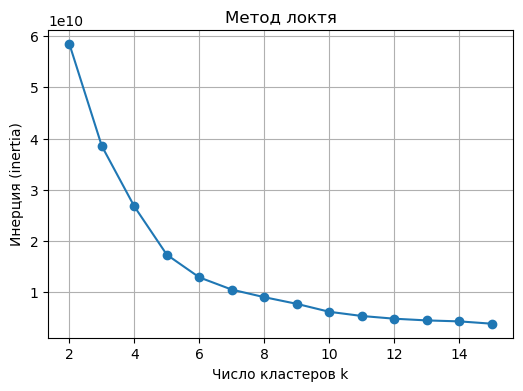

In [65]:
X_knee = X
ks = list(range(2, 16))  
inertias = []
for k in ks:
    km = MiniBatchKMeans(
        n_clusters=k,
        random_state=42,
        batch_size=2048,
        n_init="auto",
        max_iter=200
    )
    km.fit(X_knee)
    inertias.append(km.inertia_)

# 3) график «локтя»
plt.figure(figsize=(6,4))
plt.plot(ks, inertias, marker="o")
plt.xlabel("Число кластеров k")
plt.ylabel("Инерция (inertia)")
plt.title("Метод локтя")
plt.grid(True)
plt.show()


In [85]:
clients_features.describe()  

,avg_amount,total_amount,tx_count,n_currencies,n_operation_types,n_card_types,n_optype_groups,ecommerce_share,n_payment_systems,income_share,n_mcc,n_countries,n_cities,hour_diff_mean,avg_tx_per_week,weekend_share
count,936619.000000,936619.000000,936619.000000,936619.000000,936619.000000,936619.000000,936619.000000,936619.000000,936619.000000,936619.000000,936619.000000,936619.000000,936619.000000,936619.000000,936619.000000,936619.000000
mean,0.382003,103.622680,287.418514,1.471682,6.494157,2.155649,2.001988,1.089411,3.325743,1.171619,23.060287,2.293297,5.950124,98.608783,7.074501,0.283395
std,0.056512,113.886193,316.437929,1.009045,3.045690,1.234919,0.432243,0.127260,1.123231,0.232042,15.239195,1.978451,4.182342,150.840176,6.070136,0.078339
min,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,0.341823,26.511048,67.000000,1.000000,4.000000,1.000000,2.000000,1.000000,3.000000,1.026424,11.000000,1.000000,3.000000,19.681598,2.812500,0.243028
50%,0.372329,66.491199,182.000000,1.000000,6.000000,2.000000,2.000000,1.041026,3.000000,1.080000,21.000000,2.000000,5.000000,40.080952,5.322581,0.278261
75%,0.413678,141.206511,398.000000,1.000000,9.000000,3.000000,2.000000,1.121951,4.000000,1.204724,32.000000,3.000000,8.000000,100.988024,9.387755,0.315789
max,0.764208,4761.214120,9530.000000,10.000000,21.000000,14.000000,4.000000,2.000000,6.000000,2.100000,98.000000,21.000000,64.000000,1713.200000,339.333333,1.000000


Для выбранного количества кластеров обучи итоговую модель (используй K-Means из модуля sklearn.cluster с параметром init='k-means++'), поставь в соответствие каждому клиенту его прогнозный кластер.

In [69]:
k_final = 6
kmeans = KMeans(
    n_clusters=k_final,
    init="k-means++",
    n_init="auto",      
    max_iter=300,
    random_state=42
)
kmeans.fit(X)

KMeans(n_clusters=6, random_state=42)

In [70]:
clients_clusters = clients_features_scaled.copy()
clients_clusters["cluster"] = kmeans.labels_


print("Inertia:", kmeans.inertia_)
print("Размеры кластеров:")
print(pd.Series(kmeans.labels_).value_counts().sort_index())

clients_clusters.head()

Inertia: 12870042960.742039
Размеры кластеров:
0    385908
1    141912
2     73157
3     57894
4    266324
5     11424
Name: count, dtype: int64


,client_id,avg_amount,total_amount,tx_count,n_currencies,n_operation_types,n_card_types,n_optype_groups,ecommerce_share,n_payment_systems,income_share,n_mcc,n_countries,n_cities,hour_diff_mean,avg_tx_per_week,weekend_share,cluster
0,000000,0.512795,4.106233,3.484355,3.496693,1.807750,2.30327,-0.004599,0.518507,1.490573,-0.200132,3.408299,4.906217,3.837536,-0.612870,3.238194,-0.054359,5
1,000006,0.718386,1.112469,0.814004,2.505657,0.494418,-0.12604,-0.004599,-0.157690,0.600284,-0.590183,1.702172,2.378985,-0.227175,-0.551827,0.630217,-0.519468,1
2,000014,-0.649913,0.748493,0.820324,1.514620,2.136083,2.30327,-0.004599,2.055598,0.600284,-0.314161,1.308450,1.873539,2.642032,-0.549674,0.837058,-0.163756,1
3,00001d,-0.809204,-0.703190,-0.687081,-0.467454,-0.490581,-0.12604,-0.004599,-0.702584,1.490573,-0.059145,-1.053881,-0.653692,-1.183578,-0.080408,-0.684966,0.077593,0
4,000026,-0.437672,-0.476963,-0.472189,-0.467454,-0.162248,-0.12604,-0.004599,-0.531759,-0.290005,-0.677145,-0.135197,-0.653692,-0.227175,-0.254942,-0.567190,0.082462,0


Построй histplot и kdeplot для каждого признака в разрезах прогнозных кластеров.

In [78]:
df = clients_clusters.copy()
df["cluster"] = df["cluster"].astype(int)

# какие признаки рисуем
all_feats = [
    c for c in df.columns
    if c not in ("client_id", "cluster") and np.issubdtype(df[c].dtype, np.number)
]
# уберём константные
feature_cols = [c for c in all_feats if df[c].nunique(dropna=False) > 1]

/var/folders/r2/5kz0ctpd1tz454q6fy1p61nm0000gn/T/ipykernel_76890/3593889240.py:70: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


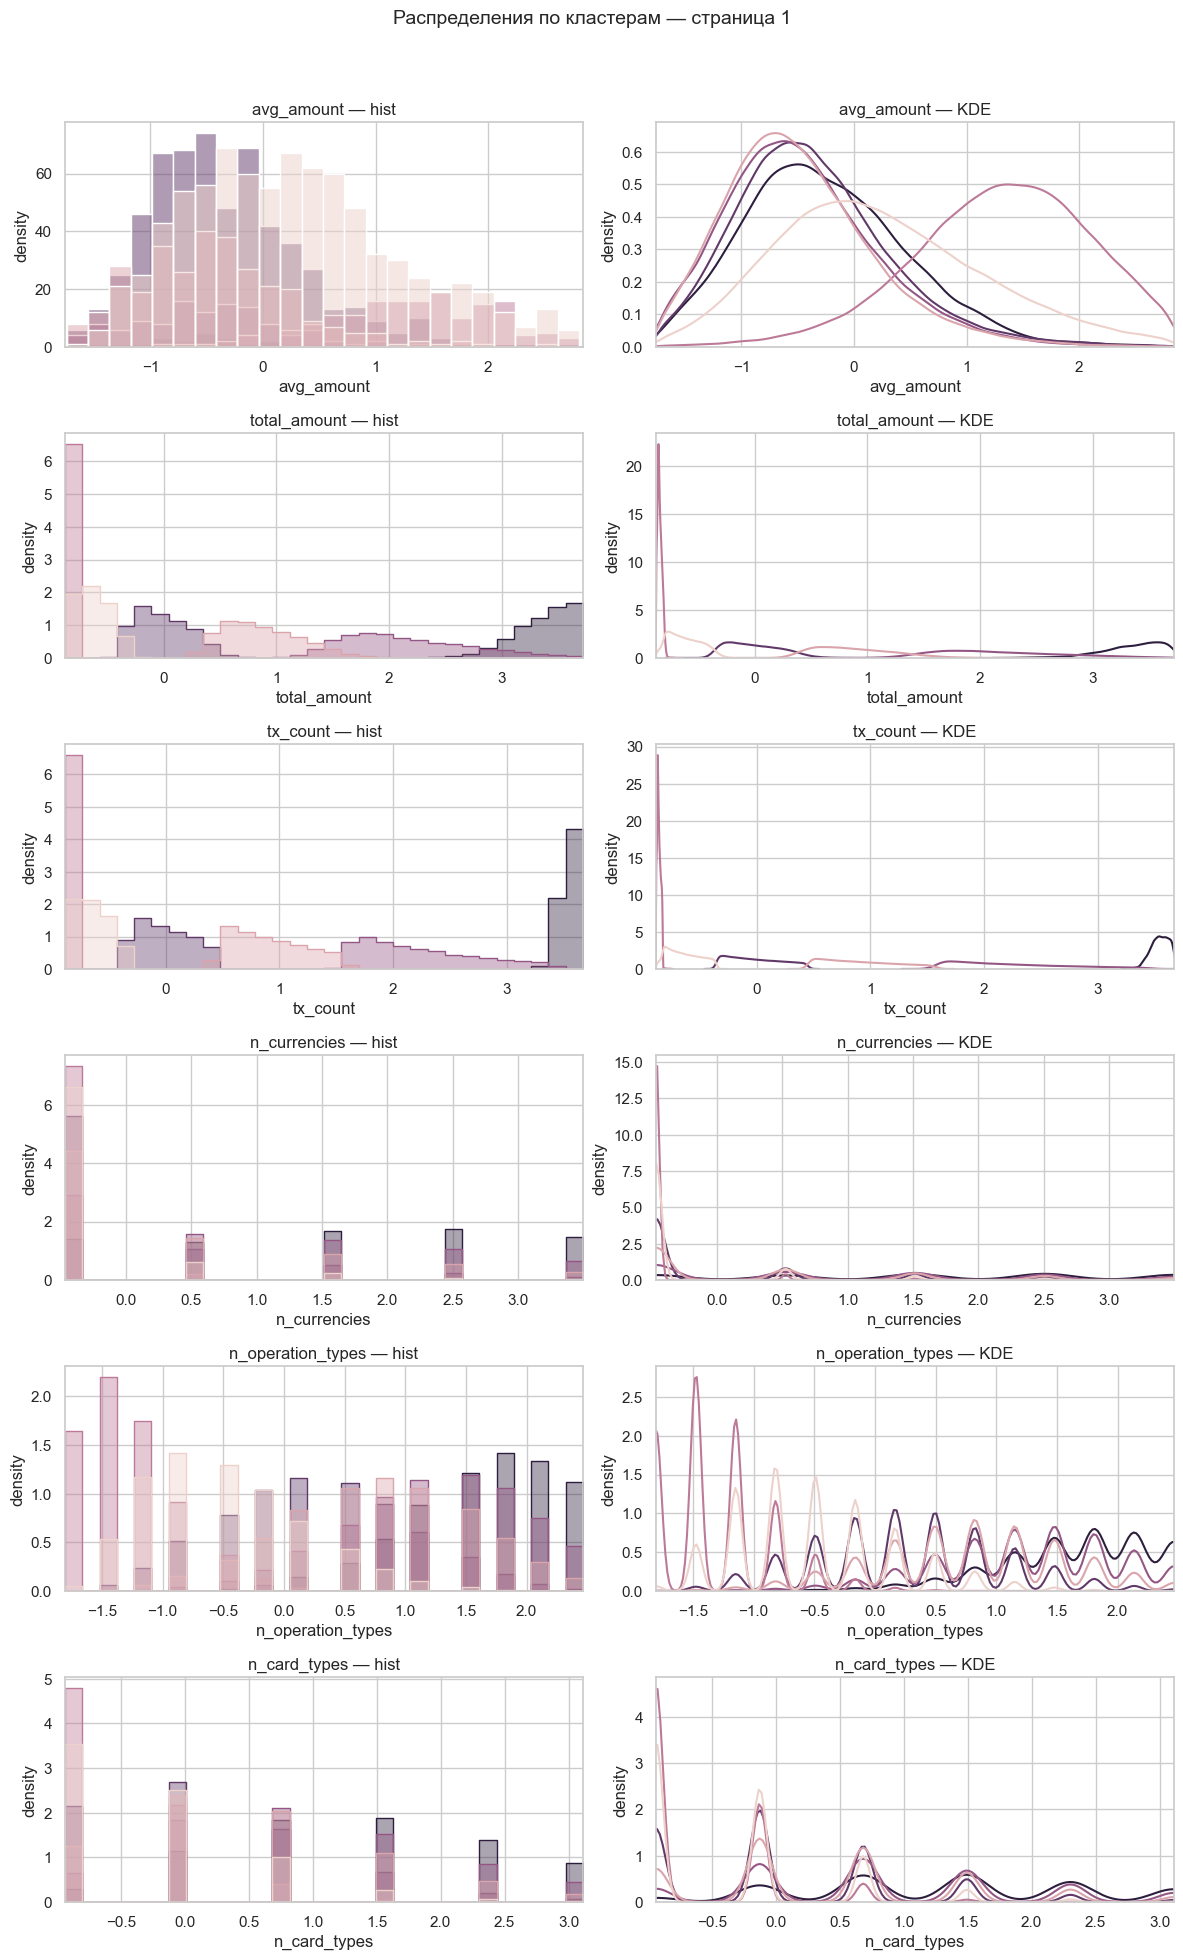

/var/folders/r2/5kz0ctpd1tz454q6fy1p61nm0000gn/T/ipykernel_76890/3593889240.py:70: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


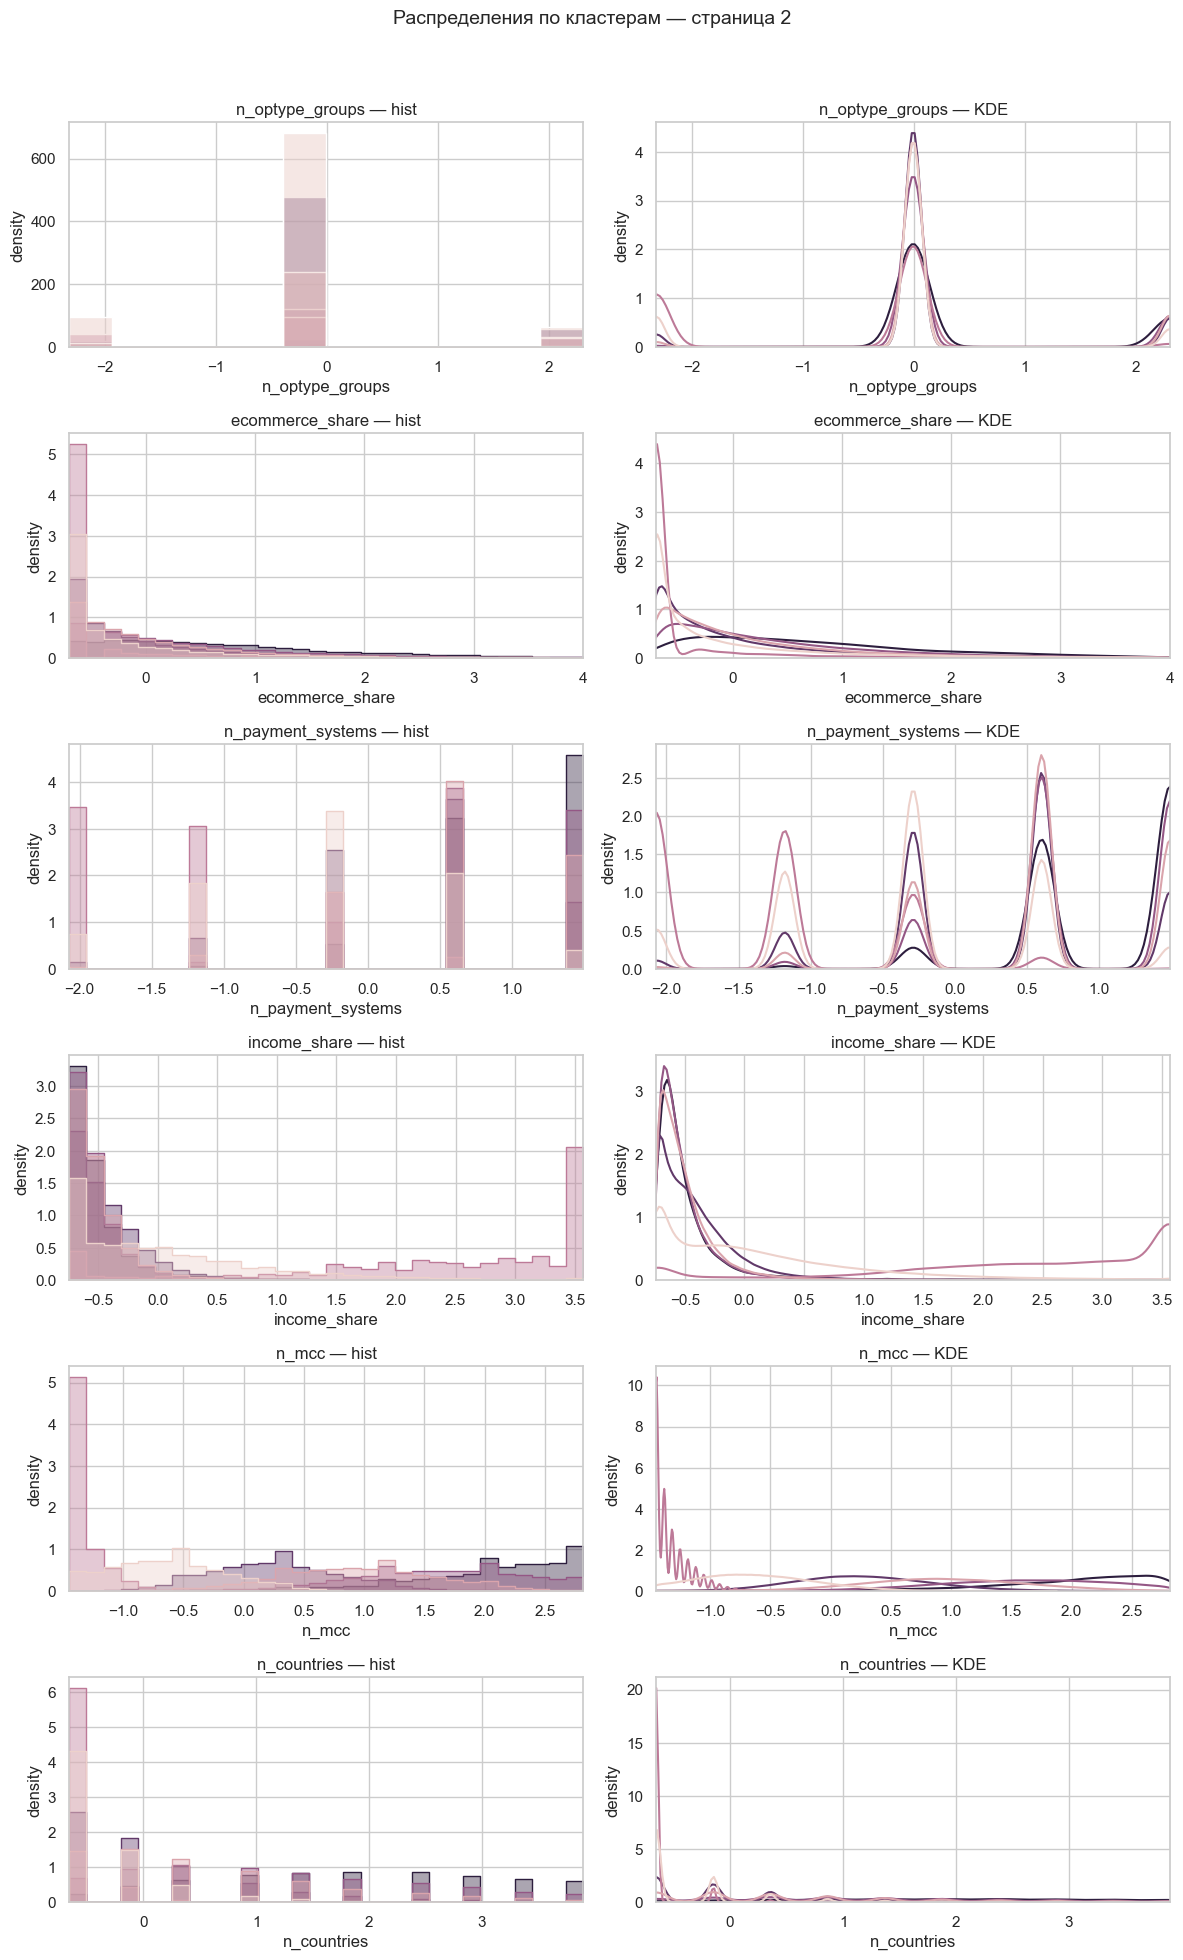

/var/folders/r2/5kz0ctpd1tz454q6fy1p61nm0000gn/T/ipykernel_76890/3593889240.py:70: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


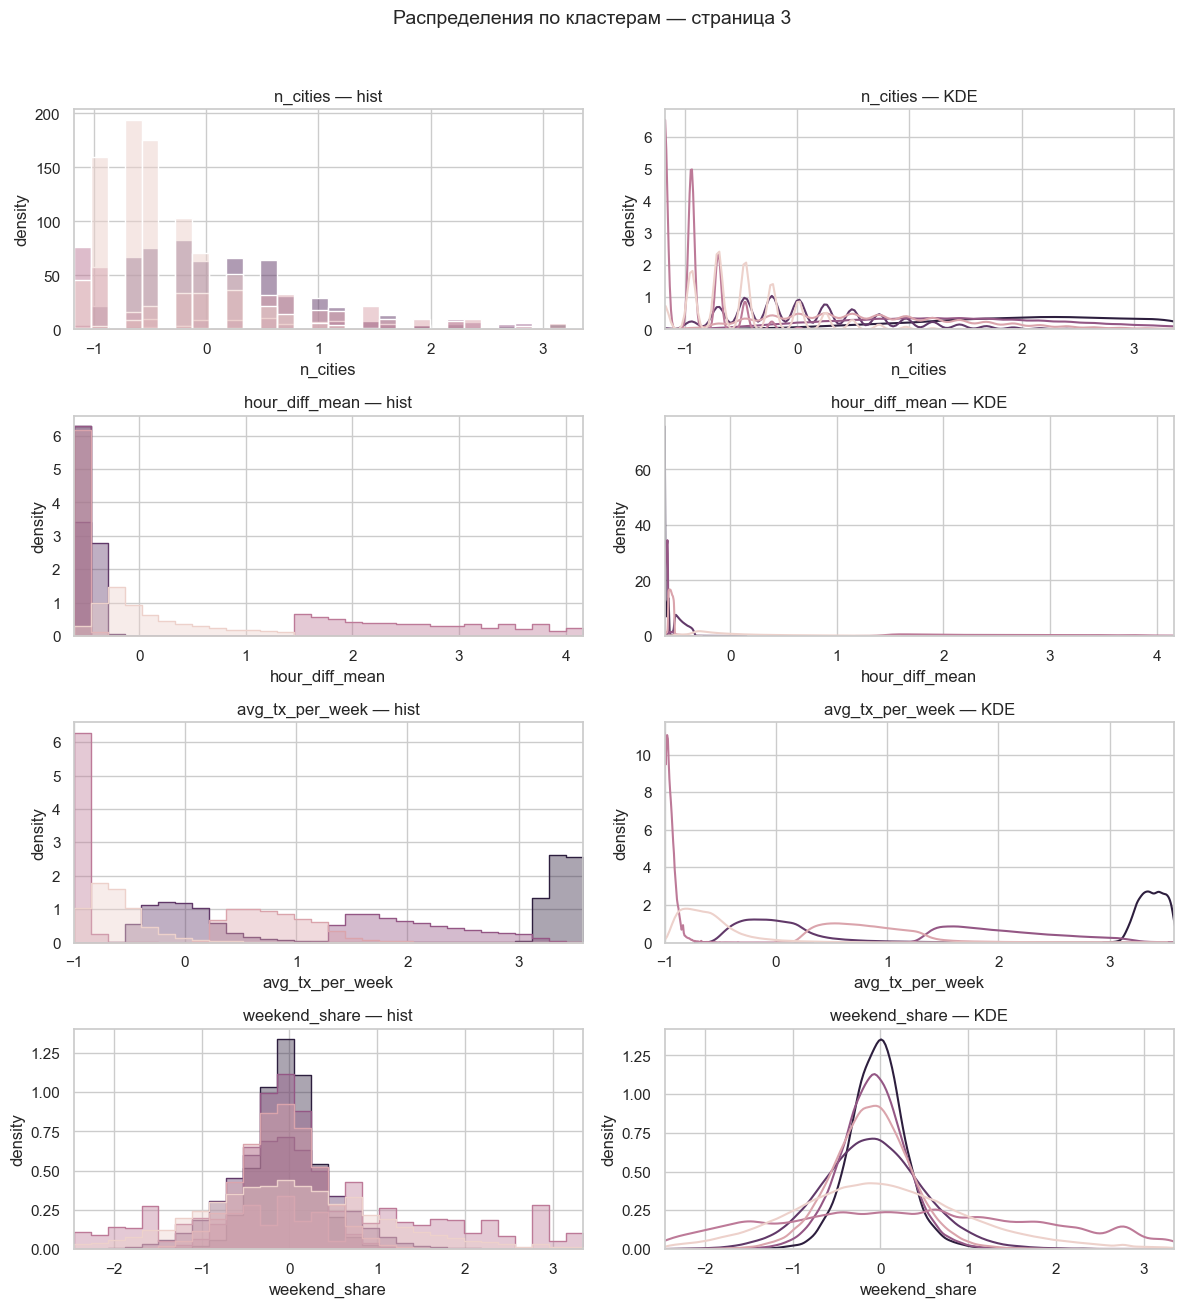

In [79]:
FEATS_PER_PAGE = 6     
BINS = 30

sns.set(style="whitegrid")

def page_chunks(lst, n):
    for i in range(0, len(lst), n):
        yield lst[i:i+n]

for page_i, feats in enumerate(page_chunks(feature_cols, FEATS_PER_PAGE), start=1):
    nrows = len(feats)
    fig, axes = plt.subplots(
        nrows=nrows, ncols=2, figsize=(12, 3.2*nrows),
        constrained_layout=True, sharex=False, sharey=False
    )

    # если один ряд — axes одномерный; приведём к двумерному виду
    if nrows == 1:
        axes = np.array([axes])

    # общий список хэндлов для легенды
    handles_labels = None

    for r, col in enumerate(feats):
        # аккуратное окно по 1–99 перцентилям (чтобы хвосты не портили масштаб)
        lo, hi = np.nanpercentile(df[col], [1, 99])
        if not np.isfinite(lo) or not np.isfinite(hi) or lo == hi:
            lo, hi = df[col].min(), df[col].max()

        data_clip = df[(df[col] >= lo) & (df[col] <= hi)]

        # HIST
        ax_h = axes[r, 0]
        sns.histplot(
            data=data_clip, x=col, hue="cluster",
            stat="density", common_norm=False, bins=BINS,
            alpha=0.4, element="step", ax=ax_h, legend=False
        )
        ax_h.set_title(f"{col} — hist")
        ax_h.set_xlim(lo, hi)
        ax_h.set_ylabel("density")

        # KDE
        ax_k = axes[r, 1]
        sns.kdeplot(
            data=data_clip, x=col, hue="cluster",
            common_norm=False, bw_method="scott",
            fill=False, ax=ax_k, legend=False
        )
        ax_k.set_title(f"{col} — KDE")
        ax_k.set_xlim(lo, hi)
        ax_k.set_ylabel("density")

        # соберём легенду один раз (по hist)
        if handles_labels is None:
            # нарисуем невидимый hist для извлечения легенды
            tmp = sns.histplot(
                data=data_clip.sample(min(2000, len(data_clip)), random_state=0),
                x=col, hue="cluster", ax=ax_h, legend=True
            )
            handles_labels = tmp.get_legend_handles_labels()
            ax_h.legend_.remove()

    # общая легенда внизу
    if handles_labels is not None and len(handles_labels[0]) > 0:
        fig.legend(*handles_labels, ncol=min(6, len(handles_labels[0])),
                   loc="lower center", bbox_to_anchor=(0.5, -0.01))

    fig.suptitle(f"Распределения по кластерам — страница {page_i}", y=1.02, fontsize=14)
    plt.tight_layout()

    plt.show()

In [87]:
df = clients_clusters.merge(
    clients_features[["client_id", "total_amount"]],
    on="client_id", how="left"
)
df

,client_id,avg_amount,total_amount_x,tx_count,n_currencies,n_operation_types,n_card_types,n_optype_groups,ecommerce_share,n_payment_systems,income_share,n_mcc,n_countries,n_cities,hour_diff_mean,avg_tx_per_week,weekend_share,cluster,total_amount_y
0,000000,0.512795,4.106233,3.484355,3.496693,1.807750,2.30327,-0.004599,0.518507,1.490573,-0.200132,3.408299,4.906217,3.837536,-0.612870,3.238194,-0.054359,5,571.265619
1,000006,0.718386,1.112469,0.814004,2.505657,0.494418,-0.12604,-0.004599,-0.157690,0.600284,-0.590183,1.702172,2.378985,-0.227175,-0.551827,0.630217,-0.519468,1,230.317477
2,000014,-0.649913,0.748493,0.820324,1.514620,2.136083,2.30327,-0.004599,2.055598,0.600284,-0.314161,1.308450,1.873539,2.642032,-0.549674,0.837058,-0.163756,1,188.865638
3,00001d,-0.809204,-0.703190,-0.687081,-0.467454,-0.490581,-0.12604,-0.004599,-0.702584,1.490573,-0.059145,-1.053881,-0.653692,-1.183578,-0.080408,-0.684966,0.077593,0,23.539147
4,000026,-0.437672,-0.476963,-0.472189,-0.467454,-0.162248,-0.12604,-0.004599,-0.531759,-0.290005,-0.677145,-0.135197,-0.653692,-0.227175,-0.254942,-0.567190,0.082462,0,49.303200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
936614,ffffc9,-0.329424,-0.507840,-0.510111,-0.467454,0.166085,-0.93581,-0.004599,-0.702584,0.600284,-0.226559,0.258525,-0.653692,-0.705376,-0.292129,-0.396669,0.536155,0,45.786749
936615,ffffdf,-1.839114,-0.524098,-0.408986,-0.467454,-0.490581,-0.12604,-0.004599,0.043424,-1.180295,-0.603223,-0.791400,-0.653692,-0.466276,-0.465781,-0.235850,-0.628271,0,43.935236
936616,fffff3,0.603150,-0.128020,-0.232016,-0.467454,1.479417,0.68373,2.308914,-0.519841,0.600284,-0.519113,0.717867,-0.148246,0.251026,-0.397068,0.093632,0.954119,4,89.042967
936617,fffff6,0.149091,-0.570484,-0.595436,-0.467454,-0.162248,-0.93581,-0.004599,-0.157974,-0.290005,-0.099568,0.127285,-0.653692,-0.466276,-0.100297,-0.621815,0.426821,0,38.652453
